# Homework 2


## Mc-Call Job Search Model with Separation

We consider here a very simple job-search model, with separation. Our goal consists in solving this model using a policy iteration algorithm. Some background on the McCall and numerical ideas are discussed on the [QuantEcon](`https://julia.quantecon.org/mccall_model.html`) website.

There is a single worker who can be either employed ("e") or unemployed ("u") in any period.

When unemployed, the jobless worker receives unemployment benefits $c_t=\alpha>0$ in every period as long as he stays unemployed. He also receives a salary offer $w_t$ which is drawn from a discrete i.i.d. distribution and takes values $w_1, ..., w_K$ with probabilities $p_1, ... p_K$ respectively.

When an unemployed worker accepts an offer in period $t$, he gets the salary $w_t$ and becomes employed. He then keeps his salary $w_t$ as long as he stays employed (for $s\geq t$, $c_s=w_t$ if $t$ is the date at which worker got the current job); in each period he has a probability $\lambda$ of becoming unemployed in the next period and remains employed otherwise.

When a worker receives a given amount $x$ his perceived utility is $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma>1.0$. A worker discounts the future at a rate $\beta \in [0,1[$. As a result, in any period $t_0$ workers seek to maximize $\sum_{t\geq t_0}^{\infty} \beta^t U(c_t)$.


__Define a parameter type `Parameter`, with fields $\alpha$, $\beta$, $\gamma$, $K$, $\sigma$, $\lambda$. Create a parameter variable $\omega$ with $\alpha=0.5$, $\beta=0.96$, $\gamma=4$, $K=10$, $\sigma=0.6$, $\lambda=0.015$__

In [ ]:
struct Parameter
    α::Float64
    β::Float64
    γ::Float64
    K::Int64
    σ::Float64
    λ::Float64
end
ω = Parameter(0.5, 0.96, 4.0, 10, 0.6, 0.015)
    

__What is the uniform distribution, whose mean is 1 and standard deviation is $\sigma$? Write a function `discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64} Vector{Float64}}` to discretize it, using $K$ points. The function should return two vectors `w` and `p` of floats of the same size `K`. Check the results satisfy the right conditions (uniformity, standard deviation).__

The pdf of a uniform distribution on an interval $[a,b]$, is $f_{a,b}(x) = \frac{1_{x\in[a,b]}}{b-a}$. The mean of this distribution is $\int f_{a,b}(x) dx = (a+b)/2$. The distribution we are looking for has mean 1, hence it must be $f_{1-\epsilon, 1+\epsilon}$ for some $\epsilon$. 
The standard deviation is: $(f_{1-\epsilon, 1+\epsilon})  = \left( \int (x-1)^2 f_{1-\epsilon, 1+\epsilon}(x) dx \right)^{\frac{1}{2}} = \frac{\epsilon}{\sqrt{3}}$. Since this is equal to $\sigma$ we must have $\epsilon = \sigma \sqrt {3}$

To discretize it, it looks natural to look for $K$ uniformly 
    distributed points between $-\epsilon$ and $+\epsilon$ i.e. $p_n = -\epsilon + \frac{2\epsilon}{K-1} (n-1)$ for $n\in [1,K]$. The probability of each point being $w_n=w=1/K$.
This is not a bad choice, but if we compute the standard deviation of this approximation we get $\sum w (p_n-1)^2 = w \sum p_n^2 - 1 = \frac{\epsilon}{\sqrt{3}} \sqrt{1-\frac{1}{(K-1)^2}} $
If we want a discretization that has accurate first and second order moments (mean, standard deviation), can must then set $p_n = -\epsilon' + \frac{2\epsilon'}{K-1} n$ with $\epsilon'=\frac{\sigma}{\sqrt{3}} \sqrt{1-\frac{1}{(K-1)^2}}$

In [ ]:
function discretize_uniform(σ::Float64, K::Int64)
    ϵ_p = σ/sqrt(3)*sqrt(1-1/(K-1)^2)
    w = [1/K for n=1:K]
    p = [1-ϵ_p + (n-1)/(K-1)*2*ϵ_p for n=1:K]
    return w,p
end

weights, points = discretize_uniform(ω.σ, ω.K)


The optimal decision of a worker is characterized by two value functions: $V^E(w)$ is the value of being employed at wage $w$ and $V^U(w)$ the value of being unemployed, while receiving job offer $w_t$. In Julia, both $V^U$ and $V^E$ will be represented by arrays `V_U` and `V_E` of size `K`.

A policy `g(w)` is a binary choice in the unemployed state: accept or reject an offer $w_t$. It will then naturally be represented by a boolean array (type `zeros(Bool, K)` to initialize one).

In [ ]:
g0 = zeros(Bool, ω.K)

__Given a policy $g$, write down the recursive equations which defines the corresponding value functions $V^{U,g}(w)$ and $V^{E,g}(w)$.__

If the worker receives an offer $w$ today, its value of not accepting it is:

$$V^{U,g}(w) = \begin{cases}
    \underbrace{U(α)}_{\text{unemployment benefits}} + \underbrace{\beta E_{w'} V^{U,g}(w')}_{\text{value of being unemployed next period}} & \text{if} g(w)=0\\
     \underbrace{U(w)}_{\text{salary}} + \lambda \underbrace{\beta E_{w'} V^{U,g}(w')}_{\text{value of being unemployed next period}} + (1-\lambda)  \underbrace{\beta V^{U,g}(w)}_{\text{value of being employed next period (same salary)}} & \text{if} g(w)=1
\end{cases}    
$$


$$V^{E,g}(w) = \underbrace{U(w)}_{\text{salary}} + \lambda \underbrace{\beta E_{w'} V^{U,g}(w')}_{\text{value of being unemployed next period}} + (1-\lambda)  \underbrace{\beta V^{U,g}(w)}_{\text{value of being employed next period (same salary)}} $$

__Write a function which takes a guess $V^{U,g}(w)$ and $V^{E,g}(w)$ and a policy function $g$ as arguments (and other model parameters) and updates the values, according to the updating equations. This function could have signature `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})::Tuple{Vector{Float64},Vector{Float64}}` where the returned vector has the same size as the supplied ones.__

In [ ]:
function value_update( V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter,  probas::Vector{Float64}, points::Vector{Float64})::Tuple{Vector{Float64}, Vector{Float64}}

    # update employment value
    n_V_E = copy(V_E)
    for i=1:length(V_E)
        w = points[i]
        utility = (w)^(1-ω.γ)/(1-ω.γ) # from salary
        # Compute continuation value
        Ew = 0.0
        for j=1:length(V_U)
            Ew +=  probas[j]*ω.λ * V_U[j]  # if job lost
            Ew +=  probas[j]*(1-ω.λ) * V_E[i] # if not
        end
        n_V_E[i] = utility + ω.β * Ew
    end
    
    # update unemployment value
    n_V_U = copy(V_U)
    for i=1:length(V_U)
        if g[i] == true # accept employment offer
            n_V_U[i] = n_V_E[i]
        else
            utility = (ω.α)^(1-ω.γ)/(1-ω.γ) # from benefits
            # Compute continuation value of being employed next period
            Ew = 0.0
            for j=1:length(V_U)
                Ew +=  probas[j]*V_U[j]
            end
            n_V_U[i] = utility + ω.β * Ew
        end
    end
    return (n_V_U, n_V_E )
    
end


__Write a function `eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}` which iterates on `value_update` find the values that satisfy the evaluation equations for policy `g`.__


In [ ]:
function eval_policy(g::Vector{Bool}, ω::Parameter, probas::Vector{Float64}, points::Vector{Float64}, η::Float64, maxit=10000)::Tuple{Vector{Float64}, Vector{Float64}}
    N = length(g)
    V_U_0 = zeros(N)
    V_E_0 = zeros(N)
    for t =1:maxit
        V_U, V_E = value_update( V_U_0, V_E_0, g, ω, probas, points)
        diff = maximum( abs.(V_U-V_U_0) )+ maximum( abs.(V_E-V_E_0) )
        if diff<η
            return V_U, V_E
        end
        V_U_0 = V_U
        V_E_0 = V_E
    end
    return V_U_0, V_E_0
end

In [ ]:
V_U, V_E = eval_policy(g_accept, ω, weights, points, η)

In [ ]:
using Plots

In [ ]:
pl = plot(V_U_0, label="Unemployed")
plot!(pl, V_E_0, label="Employed")


In [9]:
η = 1e-6
V_U_0, V_E_0 = eval_policy(g0, ω, weights, points, η)

([-66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318, -66.66665493800318], [-39.378818173902694, -33.254165363924734, -29.23083392986082, -26.47966595987709, -24.535085311066354, -23.12189313437314, -22.070297118811627, -21.271662068416724, -20.654278531757864, -20.169511204382232])


__Write a function `improve_policy(V_U::Vector{Float64}, V_E::Vector{Float64}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Vector{Bool}` which returns the improved policy given guesses for the value function(s) at for $t+1$.__

In [10]:
g_accept = ones(Bool, ω.K);
g_reject = zeros(Bool, ω.K);

In [21]:
function improve_policy(V_U::Vector{Float64}, V_E::Vector{Float64}, ω::Parameter, probas::Vector{Float64}, points::Vector{Float64})::Vector{Bool}
    
    # given the values tomorrow, for all states, we compute the values of accepting and rejecting the offer
    V_U_accept, V_E_accept, = value_update( V_U, V_E, g_accept, ω,  probas, points)
    V_U_reject, V_E_reject  = value_update( V_U, V_E, g_reject, ω,  probas, points)
    
    g_optimal = copy(g_accept)
    for n=1:length(g_accept)
        g_optimal[n] = (V_U_accept[n]>V_U_reject[n])
    end
    
    return g_optimal ## we don't need to return the new values if we are not doing a Bellman iteration
end

improve_policy (generic function with 1 method)

__Implement the policy function algorithm. Print the successive approximation errors and comment on the convergence speed.__

In [36]:
function policy_iteration(ω::Parameter, probas::Vector{Float64}, points::Vector{Float64}, η::Float64, maxit=10000)
    
    g_0 = copy(g_accept) # initially we reject all offers
    converged = false
    it = 0
    
    while !converged
        it += 1
        # evaluation step: compute the value of policy g0
        V_U, V_E = eval_policy(g_0, ω, probas, points,η, maxit)
        # given this value, make one improvement step
        g = improve_policy(V_U, V_E, ω, probas, points)
        flips = sum( abs.(g-g_0) )
        println("Iteration ", it, ". Number of flips: ",  flips)
        if flips == 0
            return (g, V_U, V_E)
        end
        g_0 = g
    end
    
end

policy_iteration (generic function with 2 methods)

In [37]:
 g, V_U, V_E = policy_iteration(ω, weights, points, η)

Iteration 1. Number of flips: 4
Iteration 2. Number of flips: 2
Iteration 3. Number of flips: 1
Iteration 4. Number of flips: 0


(Bool[0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [-5.2285157694825095, -5.2285157694825095, -5.2285157694825095, -5.2285157694825095, -5.2285157694825095, -5.2285157694825095, -5.2285157694825095, -4.940213743527914, -4.32283022027947, -3.838062903433653], [-23.047369455701332, -16.9227167787593, -12.899385432087774, -10.14821752186325, -8.203636915291534, -6.790444769294755, -5.738848776575413, -4.940213743527914, -4.32283022027947, -3.838062903433653])

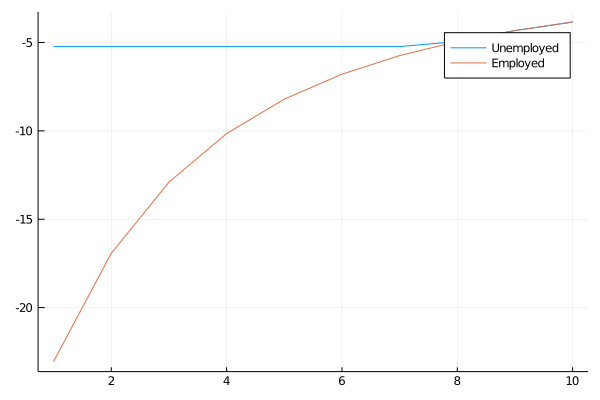

In [39]:
pl = plot(V_U, label="Unemployed")
plot!(pl, V_E, label="Employed")


Solution seems to be to reject all offers, maybe unemployment benefit is too high:

In [42]:
ω = Parameter(0.98, 0.96, 4.0, 10, 0.1, 0.015)
g2, V_U, V_E = policy_iteration(ω, weights, points, η)

Iteration 1. Number of flips: 4
Iteration 2. Number of flips: 2
Iteration 3. Number of flips: 1
Iteration 4. Number of flips: 1
Iteration 5. Number of flips: 0


(Bool[0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [-4.837850687833982, -4.837850687833982, -4.837850687833982, -4.837850687833982, -4.837850687833982, -4.837850687833982, -4.837850687833982, -4.837850687833982, -4.2435346677756485, -3.7587673522080967], [-22.968073853823334, -16.843421193031226, -12.820089856968693, -10.068921953998634, -8.124341352554532, -6.711149210284151, -5.65955322033773, -4.860918189396124, -4.2435346677756485, -3.7587673522080967])

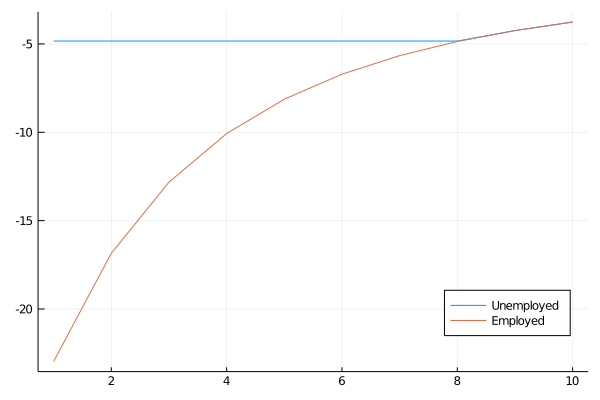

In [43]:
pl = plot(V_U, label="Unemployed")
plot!(pl, V_E, label="Employed", legend=:bottomright)


## Neoclassical growth model (2)

We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$.

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

Since the problem is time homogenous, the value function depends on available capital only and satisfies the following Bellman equation:

$$V\left(\underbrace{k}_{k_t}\right) = \max_{c\in[0,1[} U(c) + \beta V\left(\underbrace{(1-\delta)k + \underbrace{(k^{\alpha}-c)}_{y_{t+1}}}_{k_{t+1}}\right)$$

Our goal is to obtain a smooth approximation of $k$ and $V$ by using interpolations techniques.

For this model, using the dynamic first-order conditions, one can show the deterministic steady-state of the model satisfies $1=\beta \left( (1-\delta) + \alpha k^{\alpha -1} \right)$. 

__Create a suitable Parameter type to hold the parameters. Write a function `steady_state(p::Parameter)` to compute the steady-state capital `kbar` and the corresponding steady-state consumption `cbar`__ 


In [49]:
struct Param
    α::Float64
    β::Float64
    γ::Float64
    δ::Float64
end

p = Param(0.3, 0.96, 3.0, 0.1)

Param(0.3, 0.96, 3.0, 0.1)

__Set $N=10$ and define a reasonable grid `kgrid=range(kmin, kmax; length=N)` to approximate capital $k$.__


In [52]:
kbar = ((1/p.β-(1-p.δ))/p.α)^(1/(p.α-1))
kmin = kbar*0.5
kmax = kbar*1.5
N = 10
kgrid = range(kmin, kmax, length=N)

1.4604110749820356:0.3245357944404524:4.381233224946107

__The unknown value function is represented as a `N` elements arrays. Define `Vi(k,p)=U(δ * k^α)/(1-𝛽)` and compute the initial guess `V0 = [Vi(k,p) for k in kgrid]`. Define a finer grid `ktest=range(kmin, kmax;length=1000)` and find the values of `Vi` on it by  using `Interpolations.jl` library to interpolate `V0` between the points of `kgrid`.__


In [54]:
U(x,p) = x^(1-p.γ)/(1-p.γ)
Vi(k,p) = U(p.δ*k^p.α, p)/(1-p.β)

V0 = [Vi(k,p) for k in kgrid]

10-element Array{Float64,1}:
 -995.9211200566681
 -882.947409942106
 -798.7381657686765
 -733.0197777589988
 -679.9877597810237
 -636.0895889952973
 -599.0166185093636
 -567.1967665973841
 -539.5186262896792
 -515.1719273762558


__Compute a Bellman improvement function `bellman(V0::Vector{Float64}, p::Parameter, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}` which does the following steps:__

- take an initial guess `V0` for the value function

- at each grid point from kvec, optimize nonlinearly, the function $c \rightarrow U(c) + \beta V\left((1-\delta)k + (k^{\alpha}-c)\right)$ for each capital level in the grid `kvec`. In this expression the function `V()` interpolates `V0` defined on `kvec` on any point `k` so that the resulting function is continuous. 

- return the updated value and investment rules

In [61]:
using Interpolations
using Optim

In [143]:
function Bellman_step(V0, p, kgrid)
    
    V1 = copy(V0)
    c1 = copy(V0) #ill contain the policy
    for (i,k) in enumerate(kgrid)
        V = LinearInterpolation(kgrid, V0, extrapolation_bc = Line()) # a function representing value function tomorrow
        fobj(c) = U(c,p) + p.β*V((1-p.δ)*k + k^p.α - c)
        c0 = k^p.α - p.δ*k # initial guess for consumption
        upper = 0.99 * k^p.α
        lower = 0.01  * k^p.α
        ff(x) = fobj(x[1])
        res = optimize( x-> -fobj(x[1]), lower, upper)
        c = res.minimizer[1]
        c1[i] = c
        V1[i] = fobj(c)
    end
    return (V1, c1)
end

Bellman_step (generic function with 1 method)

In [151]:
V1, c1 = Bellman_step(V0, p, kgrid)
V2, c2 = Bellman_step(V1, p, kgrid)
V3, c3 = Bellman_step(V2, p, kgrid)
V4, c4 = Bellman_step(V3, p, kgrid);

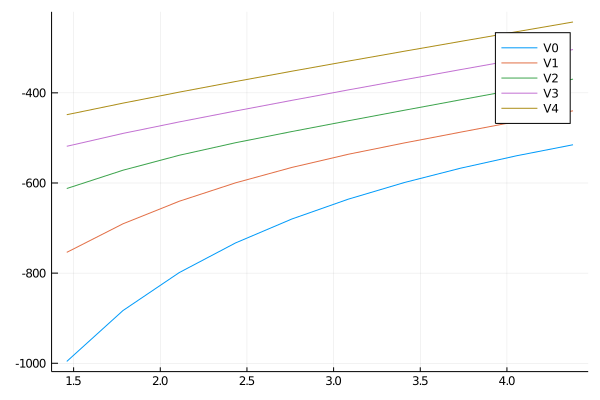

In [152]:
using Plots
pl = plot(kgrid, V0, label="V0")
plot!(pl, kgrid, V1, label="V1")
plot!(pl, kgrid, V2, label="V2")
plot!(pl, kgrid, V3, label="V3")
plot!(pl, kgrid, V4, label="V4")

It looks like the value function is increasing for each Bellman iteration

__Write a value interation function `vfi(N, p)` which solves the model defined by parameter `p` using the value function algorithm. The function should return the value function and the policy rule.__


In [164]:
function vfi(N,p; maxit=1000, tol_η=1e-8)
    # we need to recompute steady-state and grid
    kbar = ((1/p.β-(1-p.δ))/p.α)^(1/(p.α-1))
    kmin = kbar*0.5
    kmax = kbar*1.5
    kgrid = range(kmin, kmax, length=N)
    V0 = [Vi(k,p) for k in kgrid]
    for it in 1:maxit
        V1, g = Bellman_step(V0, p, kgrid)
        η = maximum(abs, V1-V0)
        if η<tol_η
            println("Converged in ", it, " iterations.")
            return V1, g, kgrid
        end
        V0 = V1
    end
end

vfi (generic function with 1 method)

In [165]:
V, g, kgrid = vfi(100, p)


Converged in 579 iterations.


([-12.284696324827294, -12.233466984901407, -12.183351581168345, -12.134304424908217, -12.086281770578337, -12.039246797400809, -11.993165043287126, -11.947998482407991, -11.903711649193802, -11.860281312245426  …  -9.78014286348344, -9.76392135969434, -9.747828327942445, -9.731860024257765, -9.716015379789836, -9.700302231280908, -9.684712441327154, -9.66923947910022, -9.653882150927988, -9.638644151389284], [0.8617557426872218, 0.8677459495546024, 0.8736883974418759, 0.8795500327976118, 0.8853357747531365, 0.8911178993376998, 0.8968360678929151, 0.9024391361956954, 0.9080867938024182, 0.9136773225901392  …  1.2240725267427135, 1.2274647493498698, 1.2307640008729817, 1.234054863961997, 1.2364005039097425, 1.2373783837207846, 1.2406623463570334, 1.243884226955254, 1.2471118076875662, 1.250581000615372], 1.4604110749820356:0.029503254040041126:4.381233224946107)

__Plot the solution. Comment.__

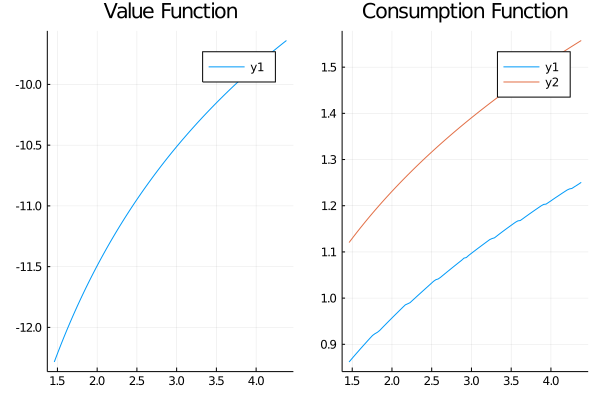

In [166]:
pl1 = plot(kgrid, V, title="Value Function")
pl2 = plot(kgrid, g, title="Consumption Function")
plot!(pl2, kgrid, kgrid.^p.α, title="Consumption Function")
plot(pl1, pl2)

__Bonus 1: plot a graph showing the convergence back to the steady-state__


In [180]:
function simulate(k0, c0, kgrid, p, T=100)
    # Consumption fule:
    c = LinearInterpolation(kgrid, c0, extrapolation_bc = Line()) # a function representing consumption rule
    sim = [k0]
    for t=1:100
        k = sim[end]
        y = k^p.α
        i = y - c(k)
        kk = (1-p.δ)*k + i
        push!(sim, kk)
    end
    return sim
    
end

simulate (generic function with 2 methods)

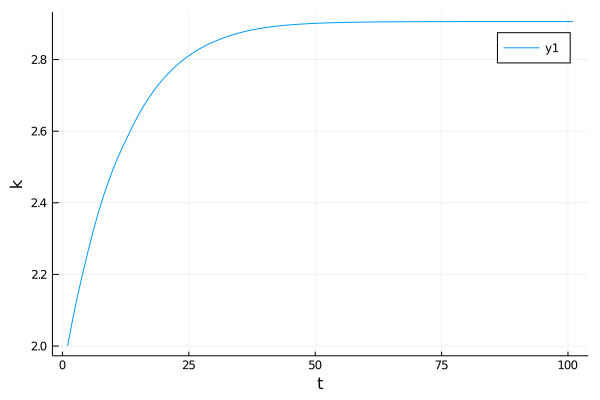

In [193]:
sim = simulate(2.0, g, kgrid, p);
plot(sim, xlabel="t", ylabel="k")

__Bonus 2: implement the policy iteration algorithm by adding an evaluation step in the `vfi` function.__


In [ ]:
function evaluate_policy(g, kgrid, p)
end
